Here are some stripes:

!['Some unremarkable stripes.'](small_stripe_mask.png 'Some unremarkable stripes')

And here are some other stripes:

!['Yep, still stripes.'](small_stripe_pattern.png 'Yep, still stripes')

What happens when we multiply these?

!['Where did you get that zebra?'](stripe_product.png 'Where did you get that zebra?')

This captures some of the flavor of [structured illumination microscopy](https://onlinelibrary.wiley.com/doi/full/10.1046/j.1365-2818.2000.00710.x) (SIM), a superresolution technique that can double the resolution of an image. The classic approach uses a sequence of images taken while illuminating the sample with a striped pattern. You need multiple images because it takes many phases and orientations to gather the Fourier domain information SIM uses to enhance the image.

For our demo, we're looking at a slightly different technique based on phase modulation that allows us to see interesting encoded images based on a single "illumination." The residual stripes that you see in the decoded image are an artifact of what we're doing here, not true SIM. You can make nice printouts with one or two transparencies and do this as a handout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter

First, let's load our image that we want to encode. `rgb2gray` mostly does what it sounds like, but there's one relevant feature that's worth commenting on. In the world of scikit-image, grayscale images are represented as floating point numbers between 0 (black) and 1 (white.) So in addition to mixing color channels into an appropriate gray, `rgb2gray` also rescales the image to fit this interval. The absolute scale of the image does matter for setting the size of the modulation later, so if you use something else to do the conversion (or load a BW image in different units directly) adjust the modulation amplitude accordingly.

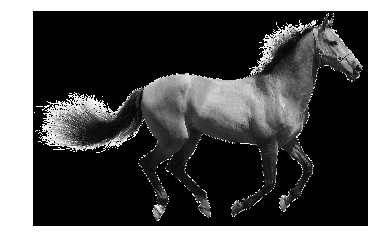

In [2]:
horse = imread('horse.png')
gray_horse = rgb2gray(horse)
plt.imshow(gray_horse, cmap='gray')
_ = plt.axis('off')

Now we want to make an illumination mask. This is a uniform series of stripes. Using sin squared conveniently puts us in our 0 to 1 interval, and also nicely mimics the intensity pattern of a standing wave set up by two counterpropagating laser beams (a common way to achieve the stripes SIM usually uses.)

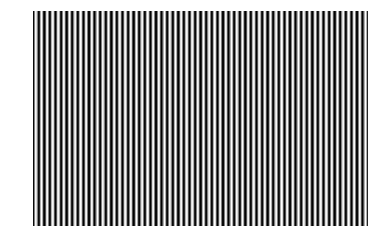

In [3]:
x_pixels = gray_horse.shape[1]
stripe_angle = 0
k_x, k_y = np.cos(stripe_angle), np.sin(stripe_angle)
y_ind, x_ind = np.ogrid[0:gray_horse.shape[0], 0:gray_horse.shape[1]]
dots_per_cycle = 16
raw_phase = (np.pi / dots_per_cycle)*(k_x*x_ind + k_y*y_ind)
stripe_mask = np.sin(raw_phase)**2

plt.imshow(stripe_mask, cmap='gray')
_ = plt.axis('off')

Next up, we encode the image. The `base_phase` here is equivalent to a stripe mask with a stripe angle of 0. We then shift the phase locally based on the grayscale value of the image we're trying to encode.

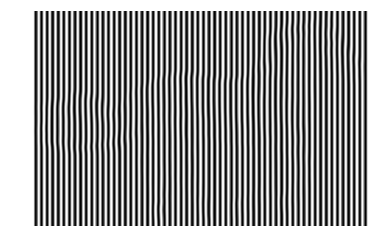

In [4]:
base_phase = (np.pi / dots_per_cycle)*np.arange(x_pixels).reshape(1, -1)
modulation_amplitude = 0.5
gaussian_sigma = 8
modulation = (modulation_amplitude *
              gaussian_filter(gray_horse, gaussian_sigma))
phase_offset = np.pi / 2
encoded_image = np.sin(base_phase + modulation + phase_offset)**2

plt.imshow(encoded_image, cmap='gray')
_ = plt.axis('off')

You'll notice that the modulation we're applying has a tunable amplitude, along with a gaussian blur. This is to reduce the distortions in the encoded stripes to subtle levels. With a larger amplitude and no blur, it's hard to hide that something is going on:

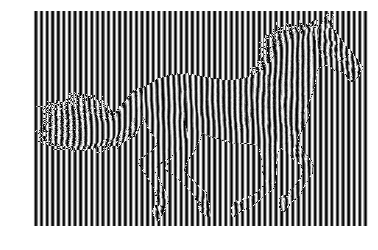

In [5]:
base_phase = (np.pi / dots_per_cycle)*np.arange(x_pixels).reshape(1, -1)
modulation_amplitude = np.pi / 2
gaussian_sigma = 0.0001
modulation = (modulation_amplitude *
              gaussian_filter(gray_horse, gaussian_sigma))
phase_offset = np.pi / 2
not_especially_encoded_image = np.sin(base_phase + modulation + phase_offset)**2

plt.imshow(not_especially_encoded_image, cmap='gray')
_ = plt.axis('off')

`skimage.color.rgb2gray` takes care of rescaling RGB images to 0 to 1 as part of its grayscale conversion. If you're not using that, then you'll probably need to do something similar to your image before using it as a phase modulation 

In the paper and transparency version of this demo, you can use the stripe mask on the transparency as an overlay to decode the paper image. The two should be oriented so that the stripes are going the same direction.

What's the right way to visualize this on the screen? Where there is black ink on the overlay, we can view that as a reduction in transmission by a factor depending on how much ink there is at a given spot. In other words, multiplication of the two images should be a good approximation to what's going on. This also lines up very nicely with actual SIM. In that case (neglecting various saturation effects) the total amount of light coming from a point in the sample will be a product of the local illumination intensity and the local density of emitters.

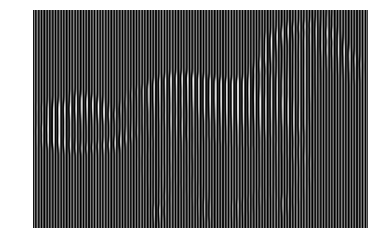

In [6]:
decoded = stripe_mask*encoded_image
plt.imshow(decoded, cmap='gray', aspect='auto')
_ = plt.axis('off')

If we don't mind having an encoded image that telegraphs that something is going on, we do get a much stronger decoded signal:

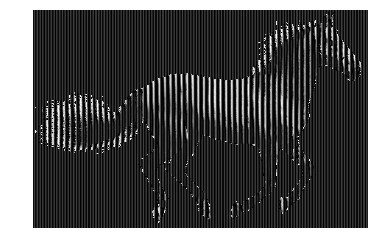

In [7]:
decoded = stripe_mask*not_especially_encoded_image
plt.imshow(decoded, cmap='gray', aspect='auto')
_ = plt.axis('off')

For best results, you want to choose your stripe periodicity so that it evenly divides the number of pixels along the x-axis. This makes the stripe grid look more visually uniform. For printouts, I just saved huge images at the dpi of the printer. You then also need to make sure that they don't get rescaled by whatever program you use to print.

So why does this phase modulation trick work? I like to think of the white space in the stripe mask as providing a new grid of "effective pixels." If we provide no modulation signal whatsoever, the encoded image will lie directly under the stripe mask. With any modulation, the stripes in the encoding get pushed out into the effective pixels. In those places, the stripes are locally fatter, and this is what we can see.